In [31]:
# Laboratorio de Datos
# Trabajo Práctico Nª 1 
# Integrantes: Román Parisi y Joaquín Núñez

In [32]:
# Importamos las librerías necesarias para el desarrollo del TP:

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import datetime # Para poder convertir al tipo datetime en el punto 1a
import matplotlib.pyplot as plt

from sklearn import linear_model    
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from formulaic import model_matrix
from formulaic import Formula

In [33]:
# Accedemos al dataset y lo observamos

datos = pd.read_csv("sube-2023.csv")
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


In [34]:
# Primera Parte: PROCESAMIENTO DE DATOS 

In [35]:
# 1.(a)

datos.dtypes # Visualizamos el tipo de datos de cada columna ("DIA_TRANSPORTE" es de tipo object)
datos["DIA_TRANSPORTE"] = pd.to_datetime(datos["DIA_TRANSPORTE"]) # Transformamos la columna "DIA_TRANSPORTE" al tipo datetime
datos.dtypes # Volvemos a ver el tipo de datos de cada columna y ahora "DIA_TRANSPORTE" es tipo datetime

DIA_TRANSPORTE     datetime64[ns]
NOMBRE_EMPRESA             object
LINEA                      object
AMBA                       object
TIPO_TRANSPORTE            object
JURISDICCION               object
PROVINCIA                  object
MUNICIPIO                  object
CANTIDAD                    int64
DATO_PRELIMINAR            object
dtype: object

In [36]:
# 1.(b)

def dia_de_la_semana(fecha: datetime) -> str:
    return fecha.strftime("%a") # Función para devolver el nombre del día de la semana dado un elemento del tipo datetime 

def fecha_ordinal(fecha: datetime) -> int:
    return int(fecha.strftime("%d")) # Función para devolver el cardinal de la fecha dado un elemento del tipo datetime 

def mes_del_año(fecha: datetime) -> str:
    return fecha.strftime("%m") # Función para devolver el número del mes dado un elemento del tipo datetime 

# Generamos nuevas columnas y les asignamos los datos pedidos utilizando las funciones de arriba

datos["FECHA_DIA"] = datos["DIA_TRANSPORTE"].apply(dia_de_la_semana) 
datos["FECHA_ORDINAL"] = datos["DIA_TRANSPORTE"].apply(fecha_ordinal)
datos["FECHA_MES"] = datos["DIA_TRANSPORTE"].apply(mes_del_año)


In [37]:
# 2.

datos_amba = datos[datos["AMBA"] == "SI"] # Tomamos solo los datos de AMBA
columnas_a_eliminar = ["NOMBRE_EMPRESA", "AMBA", "MUNICIPIO", "DATO_PRELIMINAR", "PROVINCIA", "NOMBRE_EMPRESA"] 
datos_amba.drop(columnas_a_eliminar, axis = 1, inplace = True) # Eliminamos las columnas que no aparecen en la imagen de la consigna
nombre_de_columnas = ["fecha", "fecha_dia", "fecha_mes", "fecha_ordinal", "jurisdiccion", "linea", "pasajeros", "tipo_transporte"] 
datos_amba = datos_amba.rename(columns = {"DIA_TRANSPORTE" : "fecha", "LINEA" : "linea", "TIPO_TRANSPORTE" : "tipo_transporte", "JURISDICCION" : "jurisdiccion", "CANTIDAD" : "pasajeros", "FECHA_DIA" : "fecha_dia", "FECHA_ORDINAL" : "fecha_ordinal", "FECHA_MES" : "fecha_mes"})
# Luego de renombrar las columnas les cambiamos el índice, de esta manera al hacer datos_amba.head() obtendremos lo mismo que se muestra en la consigna
datos_amba = datos_amba.reindex(columns = nombre_de_columnas)
datos_amba.head()

/var/folders/yc/m68tt0wn1mn835ws045w0rnw0000gn/T/ipykernel_1156/2123657645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_amba.drop(columnas_a_eliminar, axis = 1, inplace = True) # Eliminamos las columnas que no aparecen en la imagen de la consigna


,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


In [38]:
# 3.(a)

datos_amba["tipo_transporte"].unique() # Vemos los tipos de transporte que hay en nuesto dataframe

# Obtenemos dataframes separados por transporte

colectivos = datos_amba[datos_amba["tipo_transporte"] == "COLECTIVO"] 
trenes = datos_amba[datos_amba["tipo_transporte"] == "TREN"] 
subtes = datos_amba[datos_amba["tipo_transporte"] == "SUBTE"] 

# Tomamos la suma de los pasajeros por transporte y la total

pasajeros_colectivos = np.sum(colectivos["pasajeros"]) 
pasajeros_trenes = np.sum(trenes["pasajeros"])
pasajeros_subtes = np.sum(subtes["pasajeros"])
pasajeros_totales = np.sum(datos_amba["pasajeros"])

# Imprimimos el resultado de dividir la cantidad de pasajeros de cada transporte por la cantidad total, multiplicado por 100 y redondeado a dos dígitos decimales por comodidad

print("PROPORCION ANUAL DE PASAJEROS POR TRANSPORTE EN AMBA:")
print("Colectivo : "+str(round(pasajeros_colectivos/pasajeros_totales*100,2))+"%")
print("Tren : "+str(round(pasajeros_trenes/pasajeros_totales*100,2))+"%")
print("Subte : "+str(round((pasajeros_subtes/pasajeros_totales)*100,2))+"%")
 


PROPORCION ANUAL DE PASAJEROS POR TRANSPORTE EN AMBA:
Colectivo : 83.77%
Tren : 9.42%
Subte : 6.81%


In [39]:
# 3.(b)

max_cant_de_pasajeros = max(subtes["pasajeros"]) 
mes = subtes.loc[subtes["pasajeros"] == max_cant_de_pasajeros, "fecha_mes"].values[0] # Obtenemos el mes cuando hubo la cantidad máxima de pasajeros
linea = subtes.loc[subtes["pasajeros"] == max_cant_de_pasajeros, "linea"].values[0] # Obtenemos la línea de subte donde hubo la cantidad máxima de pasajeros
tupla = (mes,linea) # Generamos la tupla pedida
tupla

('12', 'LINEA_B')

In [40]:
# 3.(c)

datos_dias_habiles = datos_amba[((datos_amba["fecha_dia"] != "Sun") & (datos_amba["fecha_dia"] != "Sat"))] # Filtramos los datos de los días hábiles en un nuevo dataframe
desvio_estandar = datos_dias_habiles.groupby("fecha_dia")["pasajeros"].std() # Utilizamos la funcion std() de python para obtener el desvío estándar de todos los días 
desvio_estandar.idxmin() # Tomamos el índice del valor mínimo con idxmin()

'Mon'

In [41]:
# Segunda Parte: ANÁLISIS EXPLORATORIO

In [42]:
# 4.

# Vamos a analizar la cantidad de pasajeros por tipo de transporte a lo largo del año, para ver si varía la proporción y tratar de obtener alguna conclusión al respécto.

# Primero limpiamos los datos como hicimos en la Primera Parte para datos_amba

datos_limpios = datos
datos_limpios.drop(columnas_a_eliminar, axis = 1, inplace = True)
datos_limpios = datos_limpios.rename(columns = {"DIA_TRANSPORTE" : "fecha", "LINEA" : "linea", "TIPO_TRANSPORTE" : "tipo_transporte", "JURISDICCION" : "jurisdiccion", "CANTIDAD" : "pasajeros", "FECHA_DIA" : "fecha_dia", "FECHA_ORDINAL" : "fecha_ordinal", "FECHA_MES" : "fecha_mes"})
datos_limpios = datos_limpios.reindex(columns = nombre_de_columnas)

# Creamos un nuevo data frame que relacione los tres elementos que necesitamos para realizar nuestro análsis 

mes_tipo_transporte = datos_limpios.groupby(["fecha_mes", "tipo_transporte"])["pasajeros"].sum() # Agrupamos por mes y por tipo de transporte la sumatoria de los pasajeros de cada mes y tipo
datos_mes_tipo_transporte = pd.DataFrame( # Creamos el data frame mediante ciclos for 
    {"MES": [indice[0] for indice in mes_tipo_transporte.index], 
    "TIPO TRANSPORTE": [indice[1] for indice in mes_tipo_transporte.index], 
    "PASAJEROS": [mes_tipo_transporte[indice] for indice in mes_tipo_transporte.index]}
    )
datos_mes_tipo_transporte # Vemos como quedó


,MES,TIPO TRANSPORTE,PASAJEROS
0,01,COLECTIVO,248922245
1,01,LANCHAS,1206
2,01,SUBTE,16056151
3,01,TREN,24692542
4,02,COLECTIVO,242650659
5,02,LANCHAS,1071
6,02,SUBTE,15553011
7,02,TREN,22500303
8,03,COLECTIVO,332572496
9,03,LANCHAS,1325


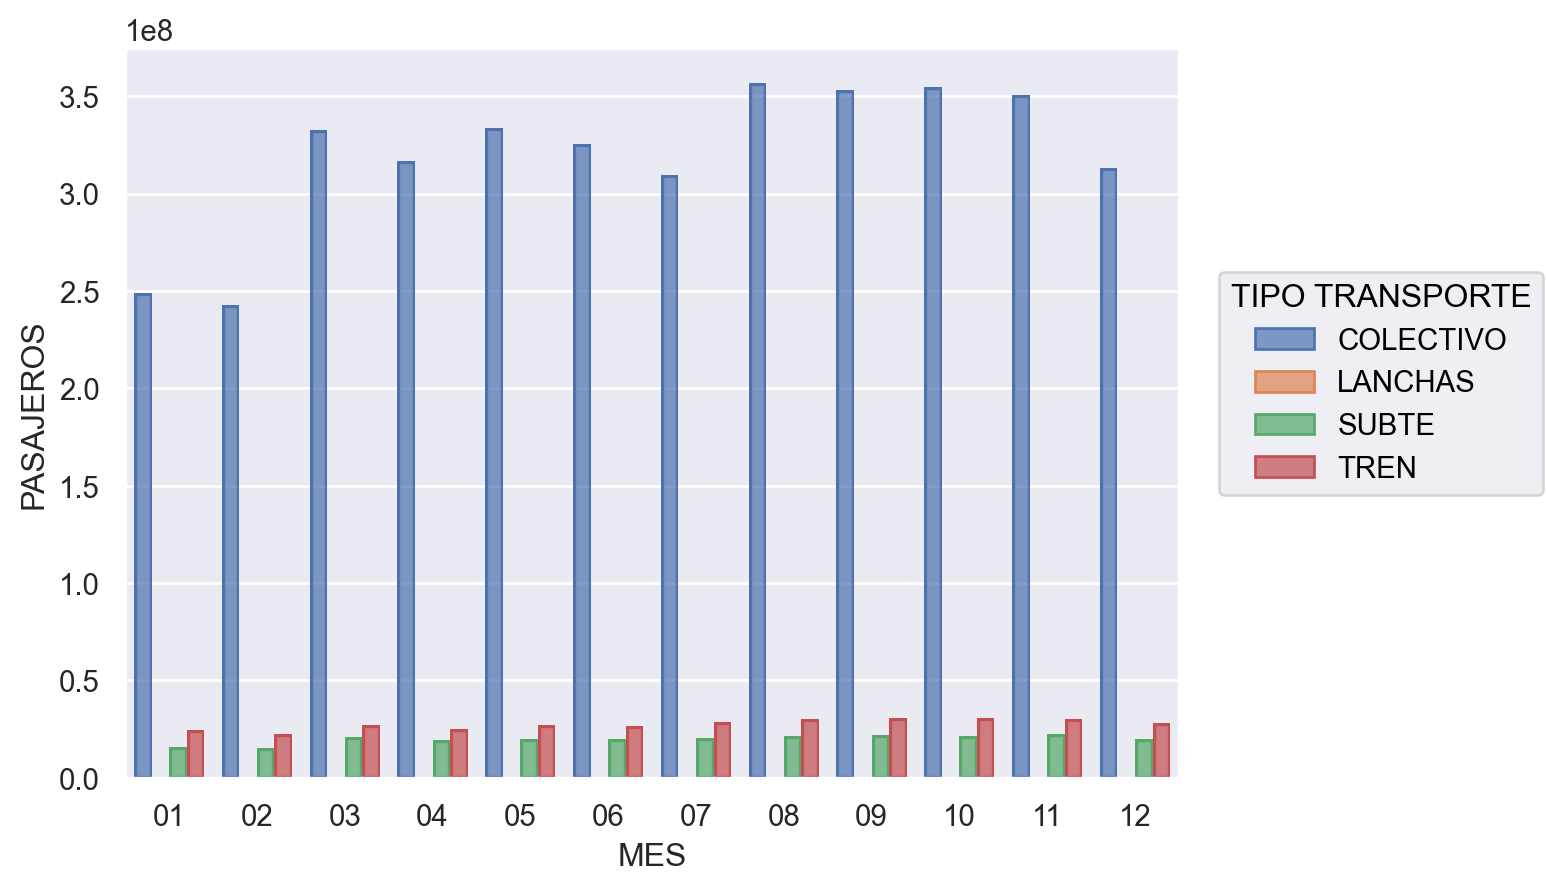

In [45]:
# Con el data frame ya creado, utilizamos el método Plot de seaborn objects para realizar un gráfico y obtener una conclusión del mismo

so.Plot(data=datos_mes_tipo_transporte, x="MES", y="PASAJEROS", color="TIPO TRANSPORTE").add(so.Bar(), so.Dodge())

In [ ]:
# CONCLUSION: la varaición en el uso del transporte para subte, tren y lancha no varían prácticamente en nada, mientras que colectivo sí, ya que presenta una baja de uso
# durante los meses de enero, febrero y un poco en julio (época vacacional). Esto nos da como indicativo que los transportes cuyo uso no varía durante el año, sean 
# probablemente de primera necesidad para sus usuarios, quienes se desplazan en trayéctos más largos sin importar si se encuentran en época laboral o no, mientras que 
# los usuarios de colectivos, por lo general, utilizan el transporte para ir a trabajar ya que hacen recorridos más cortos. Es decir, asumiendo que la mayoría de los 
# pasajeros de colectivos viven a una distancia relativamente cercana de su lugar de trabajo, o trabajan en zonas céntricas, este transporte es el que más les conviene 
# ya que hace recorridos no tan largos y alcanza las zonas céntricas de las ciudades. En cambio, los trenes y subtes hacen recorridos más largos y llegan a lugares más
# periféricos, donde, por lo general, no hay tantos lugares de trabajo como el centro de la ciudad. 


# (los resultados fueron bastante esperables y no aportan mucha información de interés)

In [ ]:
# Hagamos otro análisis más interesante
# Ahora queremos ver si hubo alguna diferencia importante en el uso de todo tipo de transporte a lo largo de los años desde 2020 hasta 2024. En especial esperamos ver una 
# clara baja en el 2020 y 2021 con respecto a los otros años por la pandemia, y ver si hubo algún cambio desde el 2023 al 2024 por el aumento de las tarifas.

In [64]:
# Leemos los nuevos data sets

datos_sube_2020 = pd.read_csv("dat-ab-usos-2020.csv")
datos_sube_2021 = pd.read_csv("dat-ab-usos-2021.csv")
datos_sube_2022 = pd.read_csv("dat-ab-usos-2022.csv")
datos_sube_2024 = pd.read_csv("dat-ab-usos-2024.csv")

# Los unimos en un solo data set

datos_sube = pd.concat([datos_sube_2020, datos_sube_2021, datos_sube_2022, datos, datos_sube_2024])

# Le realizamos las mismas modificaciones que a datos ya que resultan más cómodas y tambien obtenemos el año.

datos_sube["DIA_TRANSPORTE"] = pd.to_datetime(datos_sube["DIA_TRANSPORTE"])

def año(fecha: datetime) -> str:
    return fecha.strftime("%y")

datos_sube["FECHA_DIA"] = datos_sube["DIA_TRANSPORTE"].apply(dia_de_la_semana) 
datos_sube["FECHA_ORDINAL"] = datos_sube["DIA_TRANSPORTE"].apply(fecha_ordinal)
datos_sube["FECHA_MES"] = datos_sube["DIA_TRANSPORTE"].apply(mes_del_año)
datos_sube["FECHA_AÑO"] = datos_sube["DIA_TRANSPORTE"].apply(año)

# Y lo limpiamos

columnas_a_eliminar_2 = ["NOMBRE_EMPRESA", "AMBA", "MUNICIPIO", "DATO_PRELIMINAR", "PROVINCIA", "NOMBRE_EMPRESA", "FECHA_ORDINAL", "TIPO_TRANSPORTE", "LINEA", "JURISDICCION"] 
datos_sube.drop(columnas_a_eliminar_2, axis = 1, inplace = True)

# Vemos si los años quedaron en orden

datos_sube["FECHA_AÑO"].unique()

,DIA_TRANSPORTE,CANTIDAD,FECHA_DIA,FECHA_MES,FECHA_AÑO
0,2020-01-01,2154,Wed,01,20
1,2020-01-01,1492,Wed,01,20
2,2020-01-01,1889,Wed,01,20
3,2020-01-01,4669,Wed,01,20
4,2020-01-01,187,Wed,01,20
...,...,...,...,...,...
183846,2024-05-23,920,Thu,05,24
183847,2024-05-23,946,Thu,05,24
183848,2024-05-23,837,Thu,05,24
183849,2024-05-23,979,Thu,05,24


In [69]:
# Como el data set creado es extremadamente pesado, vamos a crear uno nuevo como hicimos para el análisis anterior, solamente quedándonos con los datos que nos interesan

mes = datos_sube.groupby(["FECHA_MES", "FECHA_AÑO"])["CANTIDAD"].sum() # Agrupamos por mes y año la sumatoria de los pasajeros de cada mes y año
datos_mes_sube = pd.DataFrame( # Creamos el data frame mediante ciclos for 
    {"MES": [indice[0] for indice in mes.index], 
    "AÑO": [indice[1] for indice in mes.index], 
    "PASAJEROS": [mes[indice] for indice in mes.index]}
    )
datos_mes_sube # Vemos como quedó

,MES,AÑO,PASAJEROS
0,01,20,313754198
1,01,21,167095783
2,01,22,219746789
3,01,23,289672144
4,01,24,261958964
5,02,20,306069353
6,02,21,174180306
7,02,22,253014089
8,02,23,280705044
9,02,24,280818381


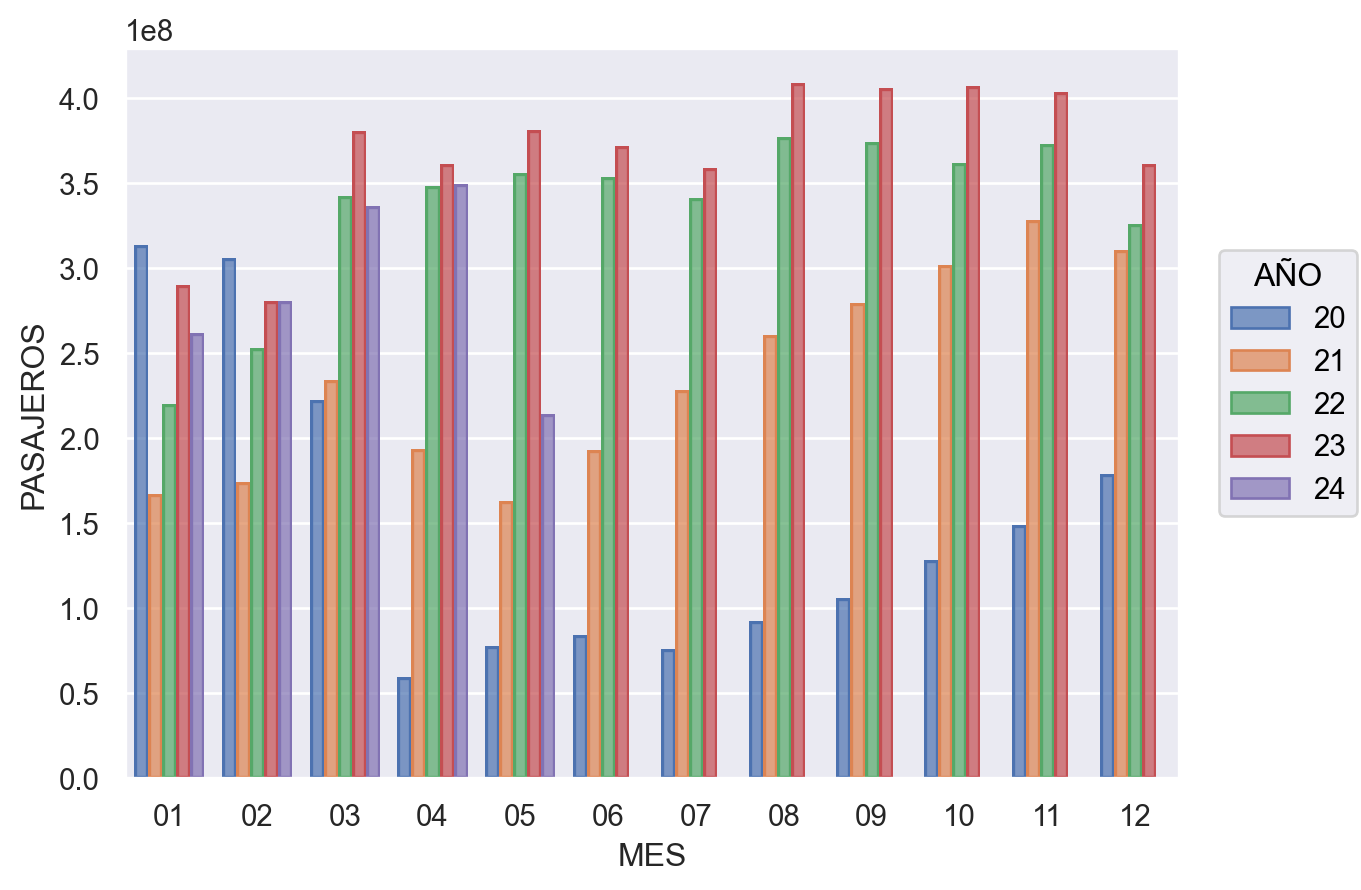

In [70]:
# Realizamos el gráfico

so.Plot(data=datos_mes_sube, x="MES", y="PASAJEROS", color="AÑO").add(so.Bar(), so.Dodge())

In [ ]:
# CONCLUSION: Como podemos ver en el gráfico, el año 2020 comenzó con normalidad, incluso fue el año cuando hubo mayor cantidad de pasajeros, lo cual no tiene una explicación
# aparente; pero luego, a partir de marzo cuando se declaró la pandemia estos números bajaron consideráblemente hacia mitad de año y luego de a poco, a medida que ciertas
# políticas de cuarentena se iban disolviendo, se empezaron a normalizar. El año 2021 tuvo un pico en verano, cuando muchas políticas dejaron de estar en vigor, y luego se 
# volvieron a aplicar durante el invieron reduciendo nuevamente la cantidad de pasajeros; finalmente, hacia fin del 2021 se normalizó esta cantidad junto con la situcación
# de pandemia. 2022 fue un año normal, similar al 2023, el cual fue, de los cuatro, el más alto, posiblemente esto se deba a los aumentos de la nafta de ese año y la mantención
# del precio de los pasajes del transporte público. Por último vemos el 2024, el cual mantuvo similitudes con el 2023 durante los primeros meses del año cuando todavía el
# precio de los pasajes no había aumentado. Estas similitudes llega hasta marzo, cuando comenzaron a aplicar los aumentos, pero a esto hay que agregarle tambien el aumento
# de la nafta, lo cual, en similitud al 2023, genera que más gente opte por el transporte público, por lo tanto la diferencia no es tan grande, hasta el mes de mayo. 
# Sin embargo este dato no lo podemos analizar correctamente ya que no sabemos si se registró completamente este mes en nuestro data set, en caso afirmativo, podemos asociar
# esta bajada, similar a la de 2021 cuando había cuarentena, con el mayor aumento que se generó en este mes al transporte y el hecho de que los precios de la nafta no hayan 
# aumentado aún más, por lo tanto la gente que puede elegir vuelve a optar por transportarse mediante vehículos privados.